**Академия аналитиков Авито**

📈 Эксперименты. Занятие 2: Сравнение двух величин

## Содержание темы:
> * [Тестовый стенд для проверки устойчивости критериев](#Тестовый-стенд-для-проверки-устойчивости-критериев)
> * [Зависимости в выборках](#Зависимости-в-выборках)
> * [Проблема подбора длины и подглядывания](#Проблема-подбора-длины-и-подглядывания)
> * [Выбросы](#Выбросы)
> * [RATIO-метрики](#RATIO-метрики)
> * [Тест Манна-Уитни](#Тест-Манна-Уитни)
> * [Бутстрэп](#Бутстрэп)
> * [Выводы](#Что-важно-запомнить)

💫 **Теги:** A/B-тест, t-тест, RATIO-метрики, тест Манна-Уитни

In [1]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import random
from itertools import combinations
import hashlib


from scipy import stats

В предыдущей части мы рассмотрели, как выглядит процесс организации количественных исследований.   
Эта часть посвящена проведению и интерпретации результатов самого базового типа экспериментов — **A/B-тестов**.  
📌 В рамках данных тестов обычно проверяется **гипотеза о равенстве средних выборок**.  


## Тестовый стенд для проверки устойчивости критериев 

При подведении результатов A/B-тестов мы проверяем гипотезы — и для этого пользуемся критериями, о которых мы говорили на прошлом занятии. Наиболее часто применяют критерий Стьюдента, который также является одним из самых быстрых тестов в плане вычислительной мощности. 
Как мы знаем, в результате применения статистических критериев мы получаем p-value — граница сверху для вероятности ошибки I рода.
Однако на практике могут возникать условия, часто не явные, которые могу приводить к смещению этой оценки как в сторону увеличения, так и в сторону занижения.
   
В этом занятии мы рассмотрим:  
   👉 Три возможных случая, в которых критерии могут приводить к *неверной оценке p-value* (зависимости в выборках, проблемы подглядывания и выбросы).  
   👉 Способы получения *альтернативных тесту Стьюдента оценок p-value* (тест Манна-Уитни, бутстрэп)  

> Так как на практике мы не всегда можем обнаружить факторы, которые могут делать критерии неприменимыми для конкретной выборки и метрики, то нам необходимо иметь инструмент для проверки критерия.  
Мы знаем что при условии, когда нулевая гипотеза верна и все предпосылки для применения критерия выполняются, результирующее распределение p-value должно быть равномерным. Можно моделировать отклонение и сравнивать распределение статистики p-value, получаемого на основе применения этого критерия  

💬 Другими словами, если мы берем нормальное распределение и выборки, для которых верна нулевая гипотеза (статистики не отличаются), то, применяя t-тест много раз, должны получить **равномерное распределение p-value**.

Итак, нам нужно оценить, насколько адекватные p-value генерируют критерии Стьюдента и другие критерии. Для этого мы будем сравнивать распределения p-value с равномерным. Когда изменение отсутствует, равномерное распределение p-value при многократном воспроизведении макетного A/B-теста будет говорить нам о том, что результатом применения критерия является именно то, что мы ожидаем: то есть вероятность ошибки I рода не выше p-value.   

На этом занятии мы будем наблюдать, как ведут себя рассматриваемые критерии в различных условиях. Так мы поймём ограничения по их применению.

**Для этого введем следующий фреймворк:**  

1️⃣ Введем `test_test` — это функция тестового стенда, которой мы передаем на вход критерий (`test_function` — например, критерий Стьюдента) и два метода генерации выборки (`array_function1`, `array_function2`), средние которых мы сравниваем при помощи критерия из `test_function`. Функцией `test_test` мы будем воспроизводить многократное проведение экспериментов в разных условиях.    

2️⃣ При многократном применении функции `test_test` получим распределение p-value для конкретных условий. В идеальном случае у p-value распределение равномерное.  

3️⃣ Если p-value распределено равномерно, мы сможем сделать вывод о том, что результат применения критерия совпадает с нашими теоретическими ожиданиями. Например, при проведении 1000 экспериментов для случайных величин, между которыми на самом деле нет различий при $\alpha$=5% мы зафиксируем ложное отклонение на 50 экспериментов (там, где его нет на самом деле — а это ошибка I рода).


Запишем функцию критерия, который будем тестировать:

In [2]:
def test_test(test_function, array_function1, array_function2): 
    tmp_array = []
    for i in range(1000):
        x1 = array_function1() #функции, которые получаем в выборке для тестирования критериев
        x2 = array_function2()
        tmp_array.append(test_function(x1,x2))
    return np.array(tmp_array)

Запишем функцию `normal_smp`, которая собирает случайную выборку из нормального распределения, и функцию t-теста (`ttest`):

In [3]:
def normal_smp(): 
    return np.random.normal(100,10,1000)

def ttest(x1,x2): 
    return stats.ttest_ind(x1,x2)[1]

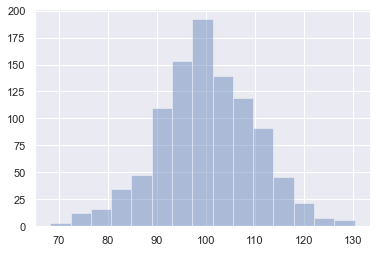

In [4]:
sns.distplot(normal_smp(), bins=15,hist=True, kde=False) #распределение выборки из нормального распределения

Поскольку наша случайная выборка была взята нормального распределения — неудивительно, что по графику она распределена нормально.

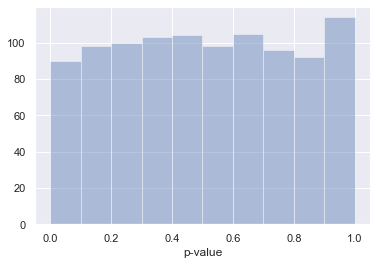

In [5]:
sns.distplot(test_test(ttest,normal_smp,normal_smp), bins=10,hist=True, kde=False,axlabel='p-value') #распределение t-теста

☝️ Распределение p-value в t-тесте равномерно.  

Понятно, что в реальности мы никогда не увидим идеально равномерного распределения со столбиками равной высоты. Поэтому графики, похожие на этот, можно рассматривать в качестве эталона. Если мы видим такой график, то мы можем сделать вывод, что рассматриваемый тест в исследуемых условиях дает адекватную оценку p-value.   

В течение этого занятия мы будем применять этот фреймворк в различных условиях и анализировать в них адекватность оценки p-value на основе рассмотрения аналогичных графиков. Таким образом, имеет смысл сравнивать последующие графики с графиком, полученным в этом разделе, в качестве *эталонного*.


## Зависимости в выборках

У большинства применяемых критериев практически всегда есть такое требование, как **независимость элементов выборки**.  
💬 *Если элементы выборки зависимы, то p-value, получаемое на основе применения критерия, может достаточно сильно отклоняться от истинного. На основе такого p-value не получится сделать правильных выводов.* 

Разные примеры зависимости в Авито:
- Пользователю при его посещении ресурса показывают рекламу. Если он раз кликнул на объявление, то вероятность того, что он кликнет второй раз, снижается.
- Есть одно объявление и два покупателя. Если один покупатель его купил, значит, второй уже не купит.
- Риэлторы из одного агентства размещают объявления и применяют услуги продвижения. Бюджет у них общий: если один потратил больше, значит, другой потратит меньше.

Рассмотрим интересный пример из производства.  

> 📊 **Пример**  
Мы провели эксперимент с оптимизацией производственного процесса.  
На графике представлен выход продукта в зависимости от дня.  
В первые 10 дней проводился эксперимент с условиями A, вторые 10 дней проводился эксперимент с условиями B.

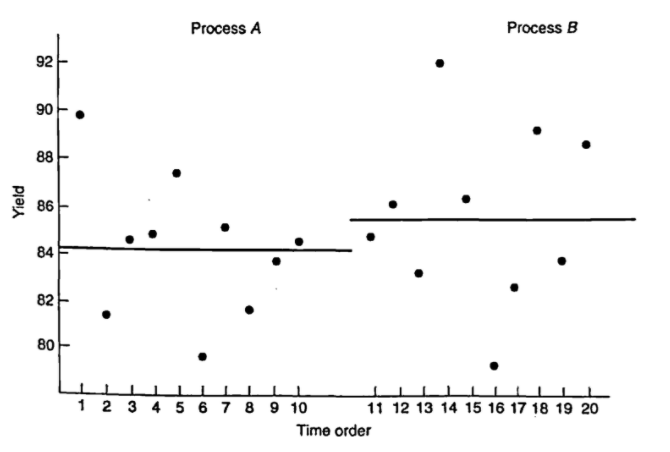

Получили средние в группах:  

${\overline y}_A=84.24$  
${\overline y}_B=85.54$  
${\overline y}_A-{\overline y}_B=1.30$  


**Является ли это отклонение статистически значимым?**  

💬 *В данном случае мы рассматриваем последовательные наблюдения и последовательные сравнения, а не A/B-тест. Однако для данной конкретной задачи мы можем использовать те же правила и цель, что и для задач с одновременным A/B-тестом — поскольку по условиям задачи нет никакой сезонности. В частности, мы можем использовать t-test.*   

Итак, сначала оценим p-value наивным методом, а потом — с помощью t-testa.  

У нас есть предыдущая история по выходу продукта за 210 дней.
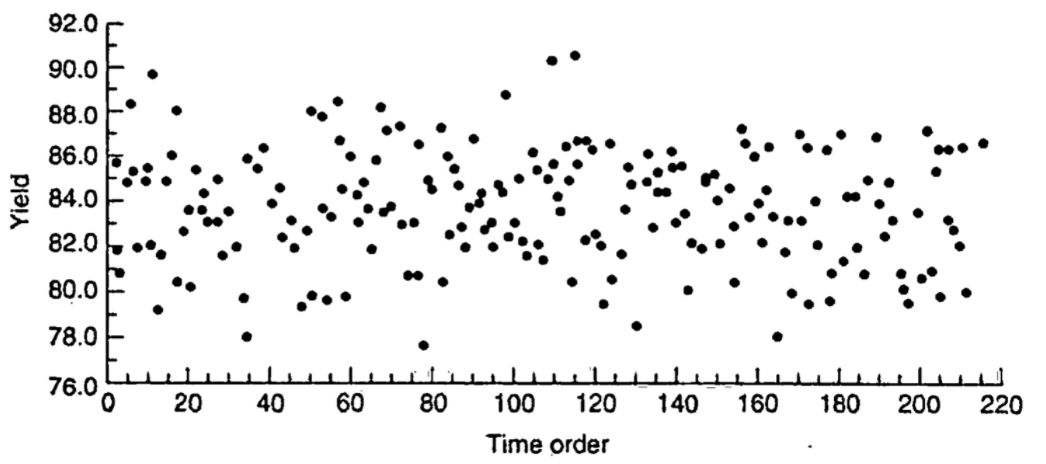

Использовали эти значения, чтобы определить, как часто в прошлом возникали различия между средними значениями последовательных групп из 10 наблюдений, которые не превышали 1.30.  
▶️ Если мы часто встречали различия меньше или равные 1.30, то это можно объяснить обычными случайными вариациями в процессе.  
▶️ Если часто встречались различия больше 1.30, более разумным объяснением было бы то, что модификация действительно произвела реальное увеличение среднего выхода.  

Возьмем первые 10 дней из 191 дня наблюдений.  
1) Сравним выход за эти 10 дней с выходом за следующие 10 дней. Различия между ними отметим на графике.   
2) Дальше сделаем шаг вперед на один день: возьмем новые 10 дней, включающие 9 дней из предыдущей десятки и еще один последующий день. Снова сравним выход за эти 10 дней и за следующие 10 дней и отметим на графике.  
3) Будем делать так, пока не закончится время эксперимента (последнее сравнение будет: 172-181 сравниваем с 182-191).  

👉 Полученный набор различий в выходе обеспечивает эталон, с которым можно сравнить наблюдаемую разницу в 1.30. Довольно редко, а именно только в девяти случаях, различия в эталонной таблице превышают 1.30.  

Если значение p-value меньше 0.05, то мы сможем сделать вывод о случайных вариациях в процессе.  

> *Применив наивный критерий на основе распределения выхода продукта, когда к нему не применены другие условия, получили p-value на уровне 4%=9/191*   
  
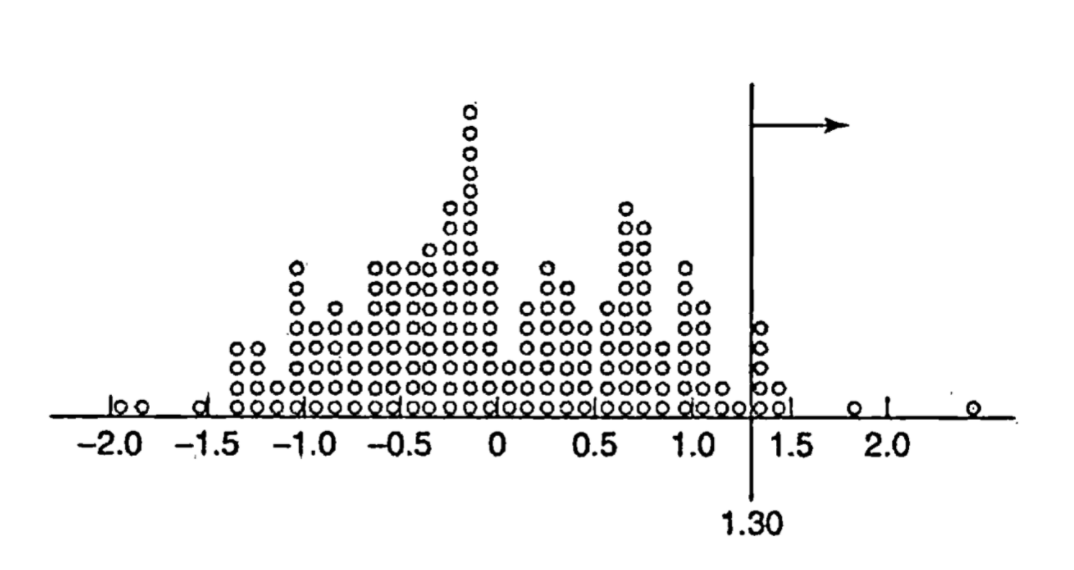

👉 Получили p-value = 4%. Его можно интерпретировать так, что статистически значимое различие в выходе между процессом А и процессом B обнаружено.  


Но если применить к результатам эксперимента t-тест, получим уровень значимости намного хуже:

In [7]:
sample1=np.array([89.7,81.4,84.5,84.8,87.3,79.7,85.1,81.7,83.7,84.5]) 
sample2=np.array([84.7,86.1,83.2,91.9,86.3,79.3,82.6,89.1,83.7,88.5])
stats.ttest_ind(sample2,sample1)

Ttest_indResult(statistic=0.8815771351054408, pvalue=0.38962608764018414)

☝️ Получили p-value, равное 38%, что намного больше 4%.  

**Почему существует большое расхождение в утверждениях о вероятности, предоставляемых этими двумя методами анализа?** 

Это было вызвано небольшой серийной корреляцией (автокорреляцией) смежных наблюдений. То есть наша первая выборка состоит из наблюдений: 89.7,81.4,... В идеале хотелось бы, чтобы эти наблюдения были независимы между собой, то есть получены из независимых случайных величин. Автокорреляция означает, что это требование нарушается: то есть значение (например, 81.4) в какой-то степени зависит от предыдущего (89.7). Наличие такой зависимости приводит к неадекватным оценкам p-value у большинства стандартных критериев, которые не предназначены для работы с автокорреляцией.  


💬 Физическая причина заключалась в следующем.   
В этом конкретном процессе выход определяется так: 
* Мы измеряли объем жидкого продукта в каждой последующей партии. Из-за конструкции системы определенное количество продукта оставалось в трубах и насосах на каждом посту.  
* Следовательно, если в конкретный день было откачано немного меньше, зарегистрированный урожай будет низким. 
* На следующий день он может  быть высоким, потому что мы не знаем точно, из какой он партии.   
Такой эффект приведет к отрицательной корреляции между последовательными выходами.  


❗ Чаще в последовательных данных возникает положительная автокорреляция, которая может привести к гораздо большим расхождениям.  

*Пример из практики:*   
Если пользователь сегодня разместил много (больше среднего) объявлений — можно предположить, что в последующие дни он разместит существенно меньше среднего.


> 💬 В данных всегда могут присутствовать явные и неявные взаимозависимости, которые, в разной степени, влияют на качество применения критериев.
<br> Результаты применения критериев, т.е. p-value, стремятся к реальной вероятности ошибки I рода. На практике p-value можно интерпретировать как силу отклонения одной группы от другой.  
 
📌 **Интерпретация p-value:**  
**p-value=0.001** — это сильно значимое отклонение.  
**p-value=0.01** — среднее по степени значимости отклонение, при таком отклонении нужно лучше понимать причины, которые к нему привели.   
**p-value=0.05** — это потенциально серая зона и такой результат применения критерия говорит о том, что на отклонение надо обратить внимание, но делать выводы исключительно по нему нельзя.

Из этого примера мы поняли, что для выборок, подверженных автокорреляции, t-test может давать p-value, сильно отличающийся от истинного. Это приведет аналитика к неверным выводам.  

👉 Решениями могут быть:  
1) использование специфических методов, созданных специально для работы с автокорреляцией, позволяющих либо избавиться от автокорреляции, либо моделировать ее. Подробнее это разбиралось в 9 занятии курса по эконометрике (ААА).   
2) изменение дизайна эксперимента для полного устранения или снижения автокорреляции или взаимозависимости в выборках, чтобы получилось использовать простые критерии (например, t-test).  

## Проблема подбора длины и подглядывания

Использовать результаты эксперимента до его окончания или продление эксперимента до получения статистической значимости приводит к **завышению значимости** в тесте.


💬 В процессе проведения эксперимента достаточно часто встречается такая ошибка, когда исследователь раньше срока начинает наблюдать статзначимое отклонение и решает его остановить или наоборот, когда в запланированный срок не получается статзначимое отклонение, и исследователь решает подержать ещё. Использовать результаты эксперимента до его окончания или продление эксперимента до получения статистической значимости приводит к завышению значимости.  


Дополнительно о завышении значимости теста можно посмотреть в [этой статье](https://www.lucidchart.com/blog/the-fatal-flaw-of-ab-tests-peeking).   

👉 Завышение значимости приводит к тому, что в некоторых случаях мы будем признавать отклонения в тех моментах, когда их нет, то есть на самом деле ошибка I рода будет выше, чем мы полагаем.  


Эмулируем нашу ситуацию:

In [6]:
#t= a + b

def test_time(test_function, array_function, alpha):
    tmp_array = []
    for i in range(20000):
        
        xa_1 = array_function()
        xa_2 = array_function()
        
        xt_1 = xa_1 + array_function() #имитируем ситуацию когда ждём ещё
        xt_2 = xa_2 + array_function()
        
        ta = test_function(xa_1,xa_2) #применяем t-тест для первой и второй выборки отдельно
        tt = test_function(xt_1,xt_2)
        if ta<alpha: # если p-value оказался ниже альфа, то останавливаем эксперимент
            tmp_array.append(ta)
        else:    
            tmp_array.append(tt)
            
   
    return np.array(tmp_array)

def normal_smp():
    return np.random.normal(100,10,100)

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

In [7]:
a=test_time(ttest, normal_smp, 0.05)

Теперь посмотрим на распределение значений p-value в имитируемом нами тесте:

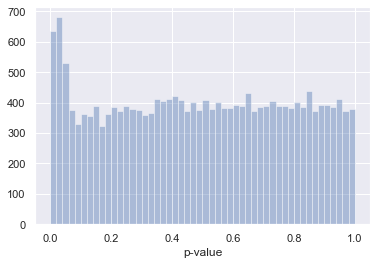

In [8]:
sns.distplot(a, bins=50,hist=True, kde=False,axlabel='p-value') 

☝️ Получили график распределения p-value. По идее, распределение должно было получиться равномерным, так как у нас не было отклонений и t-тест должен был быть ровным, но на практике ситуация иная. Разберемся далее, почему так вышло.

## Выбросы

> 📌**Выброс** — результат измерения, не попадающий под общее распределение.

Часто в выборку попадают очень не типичные её представители:

- Боты
- Power пользователи

💬 К сожалению, не существует теоретически разработанных тестов, которые учитывали бы такого рода аномалии. Поэтому на практике  можно наблюдать разного рода смещения значимости в разные стороны. Чаще всего в качестве статистики мы используем среднее, а его смещают любые выбросы, особенно сильные. Если смещена статистика, то это может повлиять и на уровень значимости.
 

Давайте рассмотрим эту ситуацию на примере.  

* Создадим две выборки из нормального распределения с параметрами (100, 10) размером 100 наблюдений каждая. 
При этом добавим в обе выборки по два наблюдения-выброса из равномерного распределения. В первую выборку будем добавлять выбросы из полуинтервала \[50,170), а во вторую — из полуинтервала \[160,180).  

* Таким образом, полученные выборки различаются только выбросами, которые составляют 2% (2 из 102).   
* Посмотрим, приведут ли эти 2% выброса к нарушению результатов `t-testа`. Для этого проведем сравнение выборок, полученных из таких СВ, с помощью `t-testa` 1000 раз (используя написанный нами ранее `test_test`).   
* Если бы выбросов не было, мы бы получили равномерное распределение p-value на этой выборке из 1000 повторений.  

Посмотрим, какой результат мы получим с выбросами.   

`Np.random.randint` — это стандартная функция по генерации случайного целого из равномерного распределения (полуинтервала). Первые два параметра — это полуинтервал, из которого нужно выбрать случайные числа в количестве, равном значению третьего параметра. 

In [9]:
def normal_smp1():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(50,170,2)))

def normal_smp2():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(160,180,2)))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

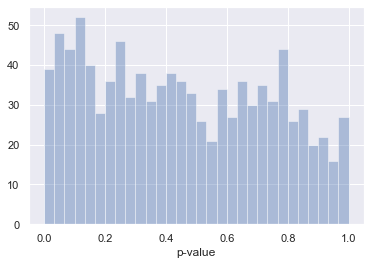

In [10]:
sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

Видим, что полученное распределение p-value менее равномерно, чем могло быть без выбросов.  
💬 *Проверим, убрав выбросы, и посмотрим, что получится :)* 

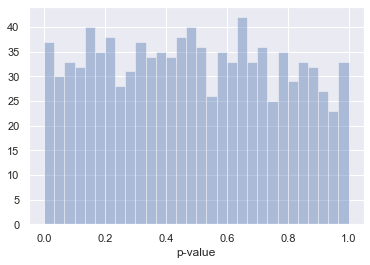

In [11]:
def normal_smp1():
    return (np.random.normal(100,10,100))

def normal_smp2():
    return (np.random.normal(100,10,100))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

Теперь посмотрим на следующую ситуацию: разница между выборками существует, но наличие 5% выбросов в выборке приводит к занижению значимости:

In [12]:
def normal_smp1():
    return np.hstack((np.random.normal(105,10,100),np.random.randint(150,170,5)))

def normal_smp2():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(160,180,5)))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

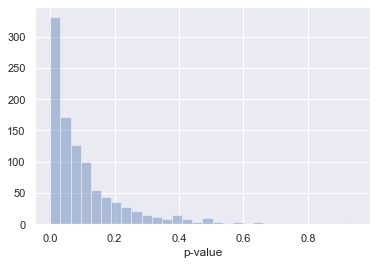

In [13]:
sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

In [14]:
def ttest(x1,x2):
    return stats.ttest_ind(x1[x1<np.quantile(x1,0.95)],x2[x2<np.quantile(x2,0.95)])[1]

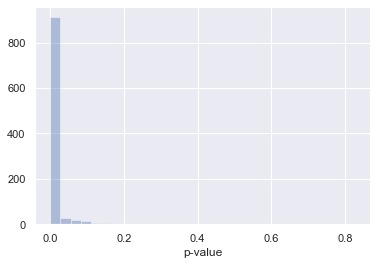

In [15]:
sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

☝️ Удаление выбросов из выборки приводит к увеличению значимости.

К сожалению, не всегда можно воспользоваться таким приёмом.

Первая проблема, с которой мы столкнёмся это наличие погрешности в определении персентиля.
Возможны случаи, когда убрав 1% сверху из контрольной и тестовой выборки, вы совершите смещение среднего.
Поэтому, прежде чем применять данный подход, необходимо провести проверку, которую мы рассматривали выше, с эмуляцией АА тестов.

Вторая проблема заключается в том, что эти элементы могут содержать важную информацию.

💬 Например, нельзя использовать этот инструмент в таких случаях:  
* если в 1% элементов содержится заметная доля всей выручки (и выручка — наша метрика),
* если это скорее отдельный кластер, а не выбросы (например, старые опытные пользователи, или наоборот порция новых).  


Так можно поступать в тех случаях, когда крайние по значениям метрик пользователи не являются типичными и результатами на этой части выборки можно пренебречь.

## RATIO-метрики

📌 RATIO-метрики — метрики конверсии.

Зачастую они больше отражают суть изменений, чем количественные:

- эффективность поиска
- конверсия в покупку
- кликабельность баннера

Часто большей чувствительностью обладают именно ratio-метрики, поскольку они **сглаживают дисперсию начала воронки**.

*Рассмотрим на примере.*  
Воронка — это последовательность действий, которая приводит к некоему целевому действию.  
Например, поисковая воронка Авито:  
▶️ посещение ресурса  
▶️ начало поиска  
▶️ просмотр объявления  
▶️ совершение контакта с продавцом  
При этом с ними есть нюансы по их интерпретации. Если брать среднее ratio по отдельным экспериментальным единицам, то в пределе они не будут приходить к реальной метрике. Но бакетное ratio будет устремляться.

👉 Именно поэтому мы не можем применять стандартные критерии (тот же t-тест) к ratio-метрикам напрямую. А вот после бакетирования мы получаем выборку с тем же значением среднего, но почти нормальным распределением — и тогда уже можем применять что угодно.  
Бутстреп тоже можно использовать вместе с ratio-метриками. 


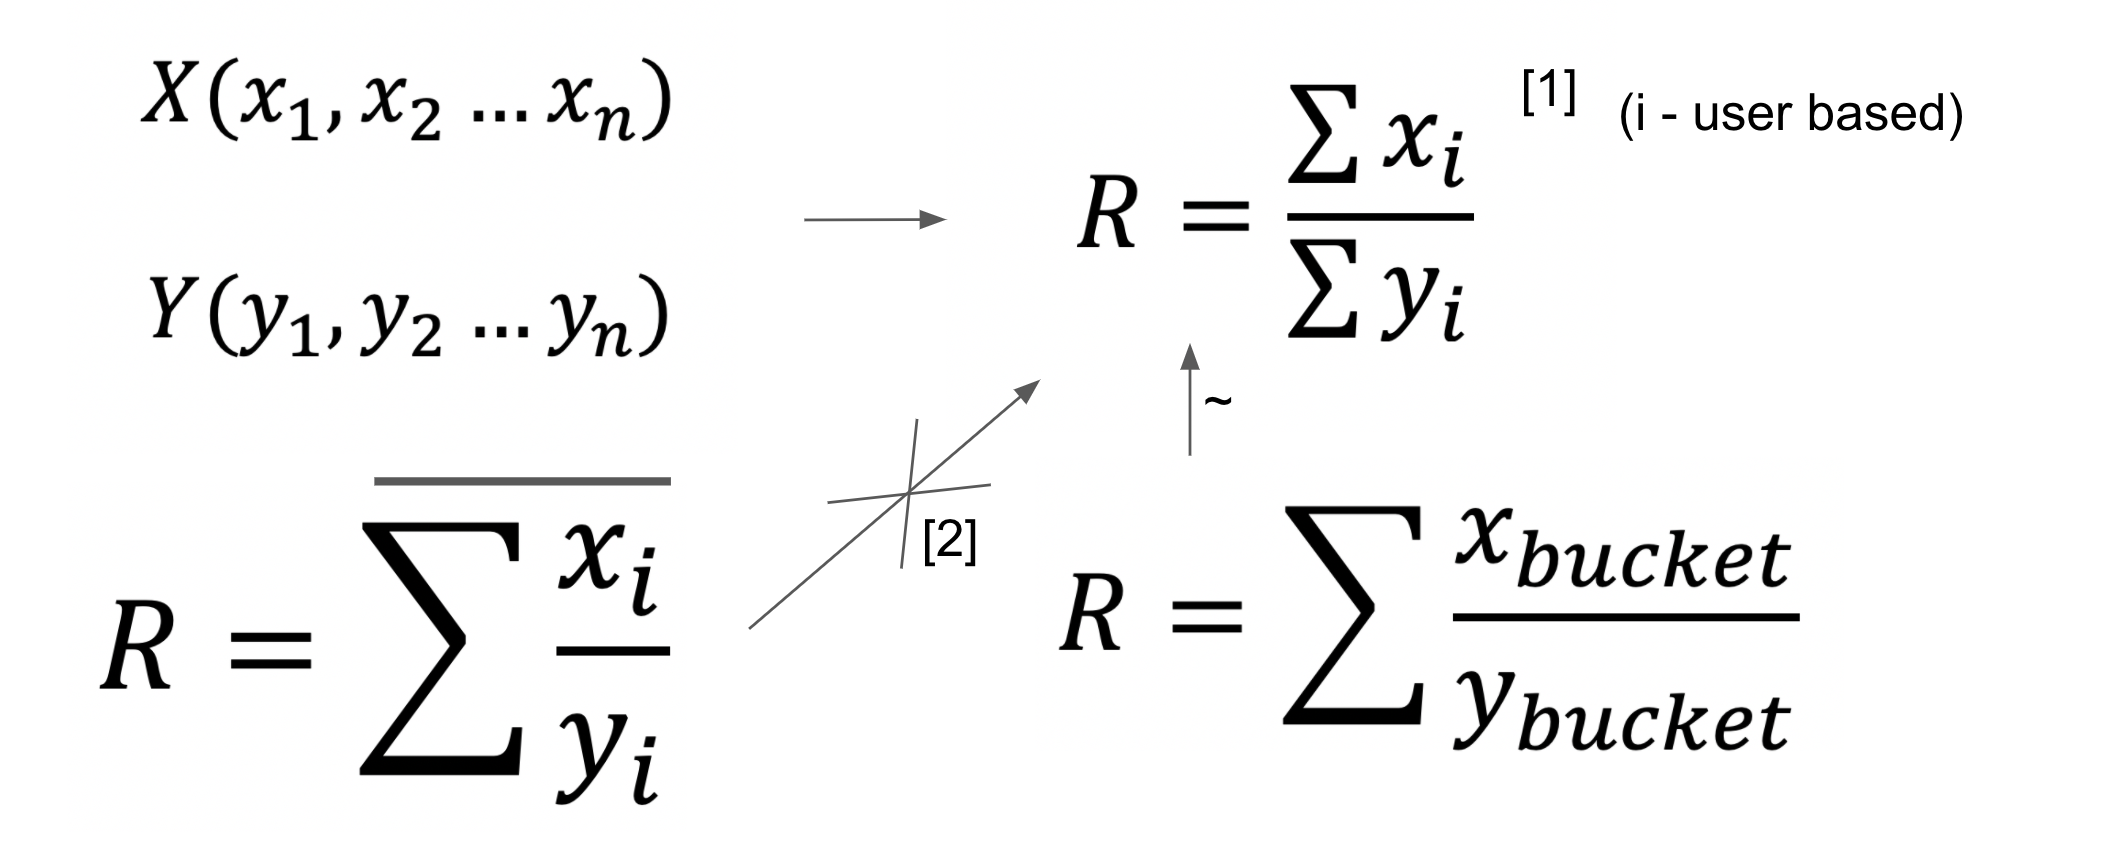

На практике не всегда ratio-метрики оказываются более чувствительными. Зависит от того, что более шумное. 
- Если конверсия более шумная, чем начало воронки, то использование ratio-метрики не поможет. 
- Если начало воронки более шумное, то применение ratio-метрики может дать результат такой, как ниже:

In [16]:
d=pd.read_csv('banner_conversion.csv')

Разделим данные на бакеты:

In [17]:
d['bucket']=d.index%50

In [18]:
d_gr = d.groupby(['bucket','test_group']).sum()[['imps','clicks']].reset_index()
d_gr['ctr'] = d_gr.clicks/d_gr.imps
control = d_gr[(d_gr.test_group=='control')]
test = d_gr[(d_gr.test_group=='test')]

Посмотрим t-статистику по кликам (*clicks*) и CTR (*ctr*):

In [19]:
stats.ttest_ind(control.clicks,test.clicks) 

Ttest_indResult(statistic=-2.575049103675405, pvalue=0.011517260839259998)

In [20]:
stats.ttest_ind(control.ctr,test.ctr)

Ttest_indResult(statistic=-3.254286981319212, pvalue=0.001560675203435189)

У *ctr* p-value ниже, что показывает большую чувствительность этой метрики к изменениям.  


## Тест Манна-Уитни

В теории тест Манна-Уитни налагает меньше требований к выборке, чем t-тест. Очевидно, что это приводит к меньшей чувствительности этого теста.

Но насколько чувствительность отличается?  
👉 Сравним эффективность с t-тестом:

In [21]:
def normal_smp1():
    return np.random.normal(103,10,100)

def normal_smp2():
    return np.random.normal(100,10,100)

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]/2

def mw(x1,x2):
    return stats.mannwhitneyu(x1,x2,alternative='greater')[1]

In [22]:
m = test_test(mw,normal_smp1,normal_smp2) #строим распределение p-value для Манна-Уитни
t = test_test(ttest,normal_smp1,normal_smp2) #строим распределение p-value для t-теста

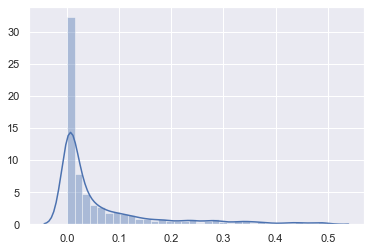

In [23]:
sns.distplot(t)

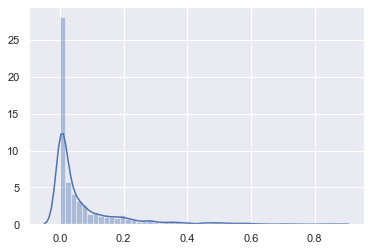

In [24]:
sns.distplot(m)

Для одной и той же выборки p-value у t-теста ниже.

In [25]:
np.median(m)

0.020003900451992022

In [26]:
np.median(t)

0.017897846656607458

*А можно ли применять тест для ненормально распределённой выборки?*

Ниже — пример того, как применился t-тест для выборки, распределённой по хи-квадрат. 


In [27]:
def chi2_smp1():
    return np.random.chisquare(2,30)

def chi2_smp2():
    return np.random.chisquare(2,30)

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

def mw(x1,x2):
    return stats.mannwhitneyu(x1,x2,alternative='two-sided')[1]

In [28]:
m = test_test(mw,chi2_smp1,chi2_smp2) #строим распределение p-value для Манн-Уитни
t = test_test(ttest,chi2_smp1,chi2_smp2) #строим распределени p-value для t-теста

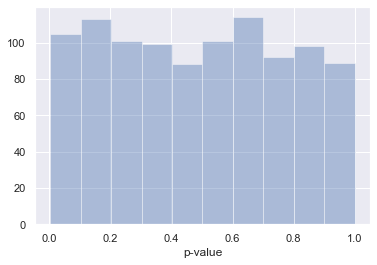

In [29]:
sns.distplot(t, bins=10,hist=True, kde=False,axlabel='p-value')

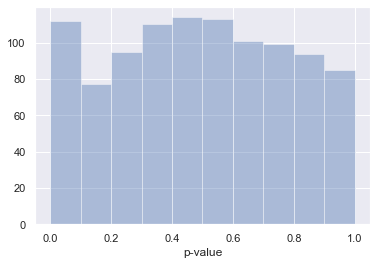

In [30]:
sns.distplot(m, bins=10,hist=True, kde=False,axlabel='p-value')

У t-теста не наблюдается завышения значимости, как и у Манна-Уитни. В случае, когда выборка отклоняется от нормального распределения (и при этом у неё нет выбросов), применение t-теста допустимо.  

👉 Рассмотрим другой случай, когда у выборки присутствует выбросы.


In [33]:
def chi2_smp1():
    return np.hstack((np.random.chisquare(2,30),np.random.randint(10,12,2)))

def chi2_smp2():
    return np.hstack((np.random.chisquare(2,30),np.random.randint(30,32,2)))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

def mw(x1,x2):
    return stats.mannwhitneyu(x1,x2,alternative='two-sided')[1]

In [34]:
m = test_test(mw,chi2_smp1,chi2_smp2)
t = test_test(ttest,chi2_smp1,chi2_smp2)

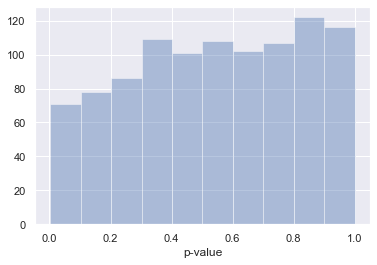

In [35]:
sns.distplot(m, bins=10,hist=True, kde=False,axlabel='p-value')

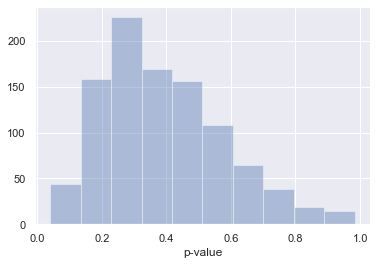

In [36]:
sns.distplot(t, bins=10,hist=True, kde=False,axlabel='p-value')

Здесь у Манна-Уитни распределение p-value гораздо больше соответствует равномерному распределению, чем у t-теста.  

Тест Манна-Уитни менее чувствителен к выбросам.

## Бутстрэп

[Бутстрэп](https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%82%D1%81%D1%82%D1%80%D1%8D%D0%BF_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0)) — более **универсальный метод** для тестирования гипотез. Он не налагает специальных требований на выборки.  


В отличие от t-теста и Манна-Уитни, он может проверять гипотезы не только о равенстве средних, но и других статистик:
- дисперсия 
- квантили

Ниже пример применения бутстрэпа для выборки со сложным распределением. В результате применения бутстрэпа для разности средних получаем нормальное распределение:

In [37]:
def stat_intervals(stat, alpha = 0.05):
    return np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

def get_bootstrap_samples(data, 
                              n_samples, 
                              custom_func = np.mean, ):
    return np.array([custom_func(data[np.random.randint(0, len(data), len(data))]) for item in range(n_samples)])

In [38]:
def control():
    return np.hstack((np.random.normal(10,3,1000),np.random.randint(20,40,49),np.random.randint(2,4,100)))

def test():
    return np.hstack((np.random.normal(10,3,1000),np.random.randint(13,18,50),np.random.randint(4,6,100)))

In [39]:
t=test()
c=control()

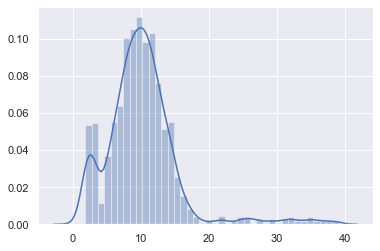

In [40]:
sns.distplot(c)

In [41]:
smp1 = get_bootstrap_samples(c,1000)
smp2 = get_bootstrap_samples(t,1000)

In [42]:
stat_intervals(smp1-smp2)

array([0.04994144, 0.82631886])

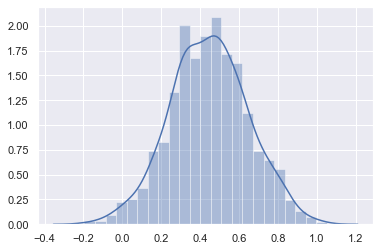

In [43]:
sns.distplot(smp1-smp2)

По графику видно, что после применения бутстрэпа распределение разницы сэмплов стало ближе к нормальному.

При всей простоте использования данного способа следует упомянуть о его недостатках:  
❗ Бутстрэп эффективен на достаточно крупных выборках >500 элементов выборки  
❗ Он намного более требователен к вычислительным ресурсам, чем предыдущие рассмотренные нами критерии

## Что важно запомнить

1) Чтобы правильно интерпретировать **A/B-тест**, можно воспользоваться критериями: параметрическими, непараметрическими и бутстрэпом.  
2) У **t-теста**, в отличие от критерия Манна-Уитни, не наблюдается завышения значимости.  
Применение t-теста допустимо, когда выборка отклоняется от нормального распределения, при этом в ней нет выбросов.   
3) **Бутстрэп** может проверять гипотезы не только о равенстве средних, но и о дисперсии и квантилях.  

4) **RATIO-метрики** — метрики конверсии, часто обладают большей чувствительностью из-за того, что они сглаживают дисперсию начала воронки.  

5) **Выбросы** можно убирать, если они не несут в себе необходимую информацию, и их вес не столь значителен.